In [2]:
# 합성곱 신경망 CNN
# 앞에서 해온 신경망은 완전 연결 계층(Affine). 인접하는 계층끼리 모든 뉴런이 연결되어있음
# 이 Affine 계층은 1차원 데이터로 평탄화를 해줘야한다는 문제가 존재.
# MNIST 데이터셋은 분명 이미지로 가로, 세로, 색상 3가지의 정보를 지니고있으나 이 정보를 한 줄로 세워 사용함.
# 합성곱 계층은 이를 3차원 데이터로 입력받아 3차원 데이터로 전달.
# 입력 데이터에 필터를 움직여가며 합성곱을 만든다

# 풀링은 여러 칸을 최댓값이나 평균값 등을 기준으로 합쳐 크기를 줄이는 것
# 학습이 필요없고 채널 수가 변하지 않으며 입력 변화에 영향을 적게 받는다

In [7]:
# im2col(input_data, filter_h, filter_w, stride=1, pad=0) 이게 input을 2차원 배열로 전개하는 함수

import numpy as np
import sys, os
sys.path.append(os.pardir)
from common.util import im2col
 
x1 = np.random.rand(1, 3, 7, 7) # 데이터 수, 채널 수, 높이, 너비
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)
 
x2 = np.random.rand(10, 3, 7, 7) # 데이터 10개
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


In [10]:
# 합성곱 계층 구현

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2 * self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2 * self.pad - FW) / self.stride)

        # 입력 데이터와 필터를 2차원 배열로 전개하고 내적
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T  # 필터 전개
        out = np.dot(col, col_W) + self.b

        # reshape : 원소 개수에 맞춰 적절하게 묶어줌.
        # transpose : 축 순서를 바꿔줌
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        return out

In [17]:
# 풀링 계층 구현
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        # 전개
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)

        # 최댓값
        # axis : 축의 방향, 0=열방향, 1=행방향
        out = np.max(col, axis=1)

        # 성형
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return out

In [18]:
# CNN 구현
import numpy as np
import sys, os
sys.path.append(os.pardir)
import matplotlib.pyplot as plt

from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient
from dataset.mnist import load_mnist
from common.trainer import Trainer

class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={'filter_num': 30, 'filter_size': 5,'pad': 0, 'stride': 1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):

        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'],
                                           self.params['b1'],
                                           conv_param['stride'],
                                           conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads

train loss:2.2998643694296756
=== epoch:1, train acc:0.294, test acc:0.256 ===
train loss:2.2982937815175486
train loss:2.2947243203967407
train loss:2.288166912458919
train loss:2.2813594131554784
train loss:2.273236356257623
train loss:2.25777721041939
train loss:2.241050407195237
train loss:2.224808320182861
train loss:2.1921901016709087
train loss:2.1647504563990423
train loss:2.119886463854106
train loss:2.0798249306588596
train loss:2.004412661606919
train loss:1.9526516103231604
train loss:1.9158806943968765
train loss:1.9291099462804306
train loss:1.8067979560510117
train loss:1.724725410353423
train loss:1.6190084039255666
train loss:1.571656939332124
train loss:1.4860846153340084
train loss:1.3765902110585377
train loss:1.3343753267514458
train loss:1.3607801352622513
train loss:1.103595152279606
train loss:1.1487581679389467
train loss:1.0692089439624306
train loss:1.1123982524978915
train loss:0.9139932483837653
train loss:0.941736805297787
train loss:0.8503318801958913
tra

train loss:0.27912935668895267
train loss:0.3268592409514293
train loss:0.24175645675567334
train loss:0.2533792902672717
train loss:0.10961062260033629
train loss:0.20754432850823748
train loss:0.162912829110657
train loss:0.3330512850341916
train loss:0.1465986937604185
train loss:0.1818960463122964
train loss:0.24944608655135606
train loss:0.36096379629051717
train loss:0.17969854643076968
train loss:0.15740873269259176
train loss:0.13043913803829243
train loss:0.13410187548616898
train loss:0.1918393900589703
train loss:0.23827871857929964
train loss:0.2522508214685106
train loss:0.2424976032765716
train loss:0.23147261617511958
train loss:0.16779176167516252
train loss:0.18797744765404553
train loss:0.2332123054794671
train loss:0.22647206613235873
train loss:0.17715530017723097
train loss:0.19391037760343413
train loss:0.13707336334960277
train loss:0.16181303141658376
train loss:0.16788879562345038
train loss:0.18184250340692876
train loss:0.07070640301311014
train loss:0.138559

train loss:0.18086563929532368
train loss:0.14114239594792463
train loss:0.13344023138879135
train loss:0.13876644122900478
train loss:0.19936331275656763
train loss:0.09965185389048001
train loss:0.09423989524793014
train loss:0.1327800006388689
train loss:0.12517620213548883
train loss:0.1328222403327729
train loss:0.04846296369606025
train loss:0.12986599282052555
train loss:0.10878991765827965
train loss:0.12013600208441386
train loss:0.1089883680030843
train loss:0.1137137278127984
train loss:0.0912253915944462
train loss:0.1000694126325569
train loss:0.1315494126660162
train loss:0.1949390662589382
train loss:0.06847328063785219
train loss:0.2135082384716675
train loss:0.18197384712936882
train loss:0.060096086361500524
train loss:0.05556255525513829
train loss:0.10941826390896259
train loss:0.047758594925235764
train loss:0.13825402373630236
train loss:0.09369994659716198
train loss:0.17895816185098126
train loss:0.07254978881938995
train loss:0.17425202993599803
train loss:0.08

train loss:0.13060859013688733
train loss:0.03809984475648159
train loss:0.04199716239702964
train loss:0.07582591305847504
train loss:0.081454329499908
train loss:0.06980356320330122
train loss:0.1498103844091636
train loss:0.052765929910234356
train loss:0.09422557459998648
train loss:0.06702992962652031
train loss:0.2149085664425299
train loss:0.04374241576434575
train loss:0.08169428274509637
train loss:0.07341092477500885
train loss:0.06079697192584302
train loss:0.042507396246733116
train loss:0.020538254910743712
train loss:0.16624911562292038
train loss:0.047568284288881865
train loss:0.08516842504140096
train loss:0.06879918934183982
train loss:0.0456223435732654
train loss:0.07830302588693788
train loss:0.09976211891500085
train loss:0.04958168644960244
train loss:0.06092498875142231
train loss:0.039530642229279954
train loss:0.07701807075175351
train loss:0.10104745615975515
train loss:0.1505517805419042
train loss:0.030629951834895124
train loss:0.045808697147151974
train l

train loss:0.11969936959947129
train loss:0.053219503657496364
train loss:0.04099676825875746
train loss:0.0505166590753839
train loss:0.03900121488623427
train loss:0.042316250914906775
train loss:0.08718743792119918
train loss:0.039406846823236606
train loss:0.07135771024936041
train loss:0.04324548457665087
train loss:0.11647324728567916
train loss:0.035116894300141144
train loss:0.047428073510744094
train loss:0.04744307908421851
train loss:0.03102741240277003
train loss:0.022947409315914605
train loss:0.041561245569307355
train loss:0.060936610117863034
train loss:0.04379854068651734
train loss:0.03706381083579777
train loss:0.13750682551223248
train loss:0.05605528601190559
train loss:0.07403603549890639
train loss:0.008419231914352373
train loss:0.08739735566543873
train loss:0.07881704890931225
train loss:0.08648849006644141
train loss:0.0648958586682014
train loss:0.028847109354536896
train loss:0.04591668216300498
train loss:0.10450758792216802
train loss:0.08626531411007063


train loss:0.15534188792293932
train loss:0.03500156277505148
train loss:0.10180017994053316
train loss:0.020277374509574665
train loss:0.06762292303950573
train loss:0.10321356304203454
train loss:0.05511900924806411
train loss:0.018917055409450673
train loss:0.06276217664737706
train loss:0.025927292333167453
train loss:0.03856953118553822
train loss:0.10941099614072
train loss:0.02932472839354374
train loss:0.03369956168274904
train loss:0.05014020326030539
train loss:0.11635953140685777
train loss:0.04112138789136863
train loss:0.045004786775143656
train loss:0.10257610040969851
train loss:0.013549619291474344
train loss:0.09067236894107297
train loss:0.03532756202189441
train loss:0.024342612924881886
train loss:0.027646152530372517
train loss:0.007452701582395435
train loss:0.06491906771920535
train loss:0.026019385218254473
train loss:0.08826657665584227
train loss:0.03429891379660287
train loss:0.051100595951666404
train loss:0.012790315174984721
train loss:0.1348666677918219
t

train loss:0.15091296728619233
train loss:0.041392885758100906
train loss:0.030439397796696535
train loss:0.09303513534361954
train loss:0.0692391201640882
train loss:0.05570601915138094
train loss:0.023521846332490867
train loss:0.018008068656305748
train loss:0.04220525475057085
train loss:0.020115971838927243
train loss:0.013962729959078235
train loss:0.01175105977689615
train loss:0.01595784974961644
train loss:0.08825401572026614
train loss:0.030401533654811755
train loss:0.05380544479049368
train loss:0.04304392227532123
train loss:0.019052214980836032
train loss:0.034462721548407384
train loss:0.03661405267758177
train loss:0.011118564651951497
train loss:0.03866980525172
train loss:0.19704404890556293
train loss:0.02451211099880654
train loss:0.029589063501706366
train loss:0.18189442043573797
train loss:0.03964891622048576
train loss:0.03644587146324072
train loss:0.019649039235122304
train loss:0.01955166690892578
train loss:0.14674457685783676
train loss:0.10857886751932538


train loss:0.03448838306292488
train loss:0.014439913237205095
train loss:0.06405288063172489
train loss:0.04645829332296922
train loss:0.07953729916239281
train loss:0.03547775993677947
train loss:0.0067395307050155786
train loss:0.039997028474766806
train loss:0.050776208122715015
train loss:0.038269213125004364
train loss:0.04795648358570281
train loss:0.027182899289201572
train loss:0.05934745647270002
train loss:0.04542116277341813
train loss:0.0607577900490162
train loss:0.027559736020472077
train loss:0.01956764167833808
train loss:0.046295089122104116
train loss:0.06714405252829451
train loss:0.12325071729296722
train loss:0.03391742572274201
train loss:0.02077949509561177
train loss:0.035962182032450614
train loss:0.048960516194988306
train loss:0.02304907988884545
train loss:0.04891112255200549
train loss:0.0786236024128108
train loss:0.03284931460182385
train loss:0.06672268398447506
train loss:0.014509349173671013
train loss:0.08407072784655378
train loss:0.0211132759789618

train loss:0.027929890989576208
train loss:0.018832262046335486
train loss:0.029680433900029845
train loss:0.009513060656007056
train loss:0.05206133338763431
train loss:0.01535689203018237
train loss:0.1030247144690227
train loss:0.06769441849854087
train loss:0.045348383746483145
train loss:0.055683464970659485
train loss:0.008412251401376353
train loss:0.08028891471917461
train loss:0.012257803163075455
train loss:0.0411721438316324
train loss:0.009931793964604143
train loss:0.04301564687814441
train loss:0.026730589145908014
train loss:0.03081144511362284
train loss:0.02005354660313181
train loss:0.054040125259015824
train loss:0.037798354030451044
train loss:0.013426922557512993
train loss:0.0074056914027812734
train loss:0.022855993315960707
train loss:0.024803526955502857
train loss:0.03769052242713675
train loss:0.07325172751105667
train loss:0.02054826295159424
train loss:0.10585855969402987
train loss:0.033831522684985856
train loss:0.03859087003603646
train loss:0.0480823448

train loss:0.05976951763868851
train loss:0.039551900581133996
train loss:0.045189081408976726
train loss:0.03346127731595366
train loss:0.02085725576977128
train loss:0.021074142129816398
train loss:0.02268313602747496
train loss:0.010255920081484994
train loss:0.06570672145951147
train loss:0.01328233167799282
train loss:0.025711684561281766
train loss:0.0411891259021929
train loss:0.041011496449984995
train loss:0.007983264273411733
train loss:0.015345632772905366
train loss:0.010635670222841828
train loss:0.031028639063668487
train loss:0.017802209733839926
train loss:0.03731370787505621
train loss:0.03539410513422742
train loss:0.03353880753029457
train loss:0.018040122380679174
train loss:0.055785363236010715
train loss:0.05457152196835786
train loss:0.08078382872929236
train loss:0.013425845872557875
train loss:0.05397371975400711
train loss:0.0360605481287889
=== epoch:5, train acc:0.981, test acc:0.981 ===
train loss:0.0029773216904363862
train loss:0.04772601501495198
train l

train loss:0.020527135813473988
train loss:0.012205973503395376
train loss:0.03917221273165412
train loss:0.057241624051200785
train loss:0.013937420806792005
train loss:0.021862585545665506
train loss:0.009811653511876977
train loss:0.017905369778220742
train loss:0.03341877400497902
train loss:0.01467295819155129
train loss:0.008273331285401867
train loss:0.017874864965445464
train loss:0.014195879581740243
train loss:0.0036959913126909656
train loss:0.041331266293906044
train loss:0.007635101013689151
train loss:0.039390654125785025
train loss:0.02250538571787262
train loss:0.012769142844713581
train loss:0.09758465228704319
train loss:0.10840005846175467
train loss:0.030625459340737456
train loss:0.03586035849587738
train loss:0.07143494154739514
train loss:0.11474702574707628
train loss:0.047457633888844
train loss:0.016161554176406735
train loss:0.011792932777802962
train loss:0.046545839877337236
train loss:0.01012152021994755
train loss:0.020209490272951217
train loss:0.0122117

train loss:0.02556657115556821
train loss:0.008587441442166097
train loss:0.05422788338813875
train loss:0.01498482418970152
train loss:0.02413555795105347
train loss:0.02302949136562292
train loss:0.010940205833684193
train loss:0.044711268758075906
train loss:0.03748094795511414
train loss:0.04122135305791349
train loss:0.004052131923594613
train loss:0.006558340221891435
train loss:0.03930901376725094
train loss:0.015475067922098079
train loss:0.01817326790767727
train loss:0.0229787576029015
train loss:0.017656946866226434
train loss:0.07550365119275715
train loss:0.009125607141609069
train loss:0.010811720778621059
train loss:0.0295137004211767
train loss:0.02331036868290765
train loss:0.0537878535845065
train loss:0.019794832674951995
train loss:0.05808458598484382
train loss:0.039622380084263435
train loss:0.015694781232042185
train loss:0.02204224401992449
train loss:0.015485208036854419
train loss:0.04798944797137764
train loss:0.03164561752435628
train loss:0.0108687076417220

train loss:0.024046577186436782
train loss:0.022526750745813864
train loss:0.01746201814695194
train loss:0.02678597989237365
train loss:0.045332871245133945
train loss:0.002840717975869997
train loss:0.02467876667886294
train loss:0.015068903369515578
train loss:0.005966711344355624
train loss:0.010165073946629417
train loss:0.006723366911444437
train loss:0.021902468088992526
train loss:0.039476782341870936
train loss:0.011589620228443308
train loss:0.018012210014856887
train loss:0.007092541728849488
train loss:0.008401957848585002
train loss:0.039659482632814484
train loss:0.026301688953704234
train loss:0.0027365022296705127
train loss:0.005903898920647552
train loss:0.010935007505259768
train loss:0.007395477486228114
train loss:0.01069065396808364
train loss:0.00407984576368933
train loss:0.024861175584276335
train loss:0.04395050568776046
train loss:0.006831352446652346
train loss:0.017823713334140852
train loss:0.008484495821962347
train loss:0.0049487855906388155
train loss:0

train loss:0.010315609488436161
train loss:0.008723509869862343
train loss:0.011028022485649411
train loss:0.012165527354576686
train loss:0.02915295249976173
train loss:0.003558088613064101
train loss:0.0066696108730241975
train loss:0.017392651861488116
train loss:0.021207382462706672
train loss:0.052649310520377204
train loss:0.008245108152360566
train loss:0.0924794628466007
train loss:0.01852177428926041
train loss:0.010981772971777033
train loss:0.02110948505489146
train loss:0.05987635307236973
train loss:0.0769815508138171
train loss:0.02318969828636016
train loss:0.07499170686714426
train loss:0.004242290004538155
train loss:0.09248899449820742
train loss:0.022489577455763198
train loss:0.0027474641483393046
train loss:0.013066694051019569
train loss:0.009302980246044958
train loss:0.006119109275309582
train loss:0.02754991547318605
train loss:0.016934069136626557
train loss:0.014236154649730895
train loss:0.005240069435288744
train loss:0.01644996243105941
train loss:0.005364

train loss:0.01630697605825354
train loss:0.024744752200090637
train loss:0.009848421246208558
train loss:0.009296857907498032
train loss:0.008547862373853056
train loss:0.012190537955078053
train loss:0.036938237606744063
train loss:0.009107835933616375
train loss:0.03322219636076411
train loss:0.007879513254521324
train loss:0.008856136807097688
train loss:0.05078623684561817
train loss:0.01075372101264596
train loss:0.010215196891588077
train loss:0.013179968651227843
train loss:0.032349562874703246
train loss:0.00433639211019107
train loss:0.023889756198698882
train loss:0.030316766998938004
train loss:0.006017314368008824
train loss:0.01193425379373712
train loss:0.013695816718930309
train loss:0.008819141786720485
train loss:0.016647392916198874
train loss:0.01548823683671039
train loss:0.017282359540462592
train loss:0.008397319874213709
train loss:0.018771876141979747
train loss:0.02339452316281632
train loss:0.03114583435906943
train loss:0.007447450803265081
train loss:0.0514

train loss:0.01539914106080373
train loss:0.013805645100677064
train loss:0.03103860564467511
train loss:0.003664511623896809
train loss:0.012520470165112067
train loss:0.015954652770182154
train loss:0.013894434647310008
train loss:0.008794937449693787
train loss:0.0014480785677309276
train loss:0.06389793805927628
train loss:0.0038878362304276158
train loss:0.014167039959328704
train loss:0.0013613202294624025
train loss:0.029443411259514662
train loss:0.006958315525227391
train loss:0.0009543042062324211
train loss:0.009382808762154096
train loss:0.015193214736523394
train loss:0.026554253667672004
train loss:0.00475342696732263
train loss:0.012920888109674053
train loss:0.008305254086879087
train loss:0.009228556799148364
train loss:0.010564209334215686
train loss:0.009156024260154978
train loss:0.010241229935612146
train loss:0.0025757513159650296
train loss:0.019170493736559026
train loss:0.009906985616229791
train loss:0.005133050984046341
train loss:0.023131903008444962
train l

train loss:0.014190597941348566
train loss:0.004854275482697334
train loss:0.0508745325345396
train loss:0.029991355371205026
train loss:0.024590546794294506
train loss:0.009718010053121841
train loss:0.0249169173647423
train loss:0.022947231518652533
train loss:0.01864313413017472
train loss:0.009256165099075621
train loss:0.024198690448729153
train loss:0.043489300274088184
train loss:0.018009216297855936
train loss:0.018356389846949116
train loss:0.0048286319552757005
train loss:0.011425198937985794
train loss:0.0043219214746703484
train loss:0.011296065731203921
=== epoch:8, train acc:0.99, test acc:0.979 ===
train loss:0.008011573056487205
train loss:0.02909186608096532
train loss:0.010087298201091666
train loss:0.010030207841474577
train loss:0.0024413391570841485
train loss:0.004545718723995699
train loss:0.00791716251321083
train loss:0.0016274804084575698
train loss:0.009671511958949434
train loss:0.011224633249548905
train loss:0.0049607199065244715
train loss:0.0067485914602

train loss:0.030056168770540327
train loss:0.013573398056493925
train loss:0.011016204640042907
train loss:0.007435668004832336
train loss:0.00444471365757208
train loss:0.013852554355494763
train loss:0.014077320788871934
train loss:0.04093332041793017
train loss:0.020404962287889936
train loss:0.007974247662294197
train loss:0.0010904715417362932
train loss:0.03325809154454414
train loss:0.05221488976345883
train loss:0.007656134159224185
train loss:0.019838999122346636
train loss:0.008045667297109234
train loss:0.011313094424661678
train loss:0.009052277298648026
train loss:0.08195418773837469
train loss:0.0028560461719543658
train loss:0.002739504835454009
train loss:0.004207589585754869
train loss:0.013147021202203051
train loss:0.0029430934521724773
train loss:0.0031825715689927634
train loss:0.03310474460454939
train loss:0.020668494990224506
train loss:0.011832407018761986
train loss:0.0017370982644385885
train loss:0.009607033064245039
train loss:0.004917398071034895
train los

train loss:0.00715474518628195
train loss:0.005094822265798909
train loss:0.008905067843712484
train loss:0.0563583162695678
train loss:0.01802316085318511
train loss:0.016038463466691383
train loss:0.0030779807501586463
train loss:0.0008450059743101717
train loss:0.006667817173892095
train loss:0.004977500720527308
train loss:0.004702626861252733
train loss:0.0025484533500819227
train loss:0.010503340277258017
train loss:0.006297848851440491
train loss:0.021046206903575677
train loss:0.006632232135571106
train loss:0.059916185393002815
train loss:0.005485687840881126
train loss:0.0021073879121257257
train loss:0.01200808323598226
train loss:0.00900248107086079
train loss:0.004799130623878627
train loss:0.0014898145198559238
train loss:0.0046115947802272995
train loss:0.0011449206832910472
train loss:0.00899324884505049
train loss:0.017752646027533823
train loss:0.008358920868095244
train loss:0.008339508998055021
train loss:0.004414981991656356
train loss:0.003031371390723162
train lo

train loss:0.014076682821812935
train loss:0.02408511790286598
train loss:0.008597034839875074
train loss:0.0048629000039139645
train loss:0.00544704188832884
train loss:0.01215552132403369
train loss:0.0006530349342139624
train loss:0.010699939129199133
train loss:0.010465410497839491
train loss:0.009386211805656084
train loss:0.05250493452663209
train loss:0.005221670038181594
train loss:0.07397217895875502
train loss:0.05733826753285396
train loss:0.02543333842262752
train loss:0.012572300822840596
train loss:0.002452939298634946
train loss:0.001318064547667231
train loss:0.002951551992780256
train loss:0.04980583927268792
train loss:0.004052244379476665
train loss:0.01048688316988503
train loss:0.0017231629463431977
train loss:0.0038865503068609194
train loss:0.004188840975995633
train loss:0.008831568868742624
train loss:0.033725901317473356
train loss:0.008764618512680409
train loss:0.0031063150520243004
train loss:0.006773595087494288
train loss:0.004695223931943897
train loss:0

train loss:0.004574936078882577
train loss:0.0033268517718193034
train loss:0.012674813566688507
train loss:0.0037519066704879934
train loss:0.0024401856574607812
train loss:0.0016617398631692973
train loss:0.010155028460835302
train loss:0.006272522770051051
train loss:0.0014174224602563521
train loss:0.003677352881141228
train loss:0.07645569311092423
train loss:0.008258158139502451
train loss:0.004842641819851588
train loss:0.006112145449490118
train loss:0.008096338353209298
train loss:0.01685371628256544
train loss:0.020990725473532503
train loss:0.005253385790679421
train loss:0.002913015342801183
train loss:0.007622449157417449
train loss:0.011343538441219768
train loss:0.0033971420345485577
train loss:0.0009251258917649791
train loss:0.005778874532294715
train loss:0.012535727971125994
train loss:0.019344163152211654
train loss:0.0008801038798354978
train loss:0.0005061676648994175
train loss:0.019246975859460284
train loss:0.06556646795860031
train loss:0.00494899277472763
tra

train loss:0.0026611551962217243
train loss:0.01043885571248608
train loss:0.004764083876301956
train loss:0.005791161627799575
train loss:0.0015283595961496901
train loss:0.0024039756379027185
train loss:0.004730786581349934
train loss:0.006858200477534607
train loss:0.005571916165250188
train loss:0.004154160350344384
train loss:0.013658927783503378
train loss:0.011400942302825285
train loss:0.00263730252329211
train loss:0.003530611485719501
train loss:0.013886881432057956
train loss:0.007853863317861705
train loss:0.009181496274310412
train loss:0.003127923574515379
train loss:0.0006706406246868754
train loss:0.013140071924751777
train loss:0.02054525943201987
train loss:0.004498151882282874
train loss:0.04034274835869216
train loss:0.0021970814436636467
train loss:0.017017870227488862
train loss:0.009072657511834746
train loss:0.0010223316568436361
train loss:0.008242796745424993
train loss:0.010535714960672536
train loss:0.01103084053006368
train loss:0.01438551772126293
train lo

train loss:0.005748402624254898
train loss:0.005029136441525705
train loss:0.01388195858185608
train loss:0.006372289914381083
train loss:0.01059316981133368
train loss:0.006901206783823975
train loss:0.0031326700713733393
train loss:0.002720676729020553
train loss:0.008255886705210592
train loss:0.003840442675448958
train loss:0.0008203196846335384
train loss:0.012618756759684187
train loss:0.00511825995116725
train loss:0.0018442158428706185
train loss:0.008575058688697297
train loss:0.017802235955504134
train loss:0.003622880688170769
train loss:0.004328688501705666
train loss:0.0025399040445603844
train loss:0.006189079676300334
train loss:0.00941361398798175
train loss:0.019000419884875788
train loss:0.02407315508190019
train loss:0.0181655528314315
train loss:0.0017930545344185989
train loss:0.0011953771603056926
train loss:0.027117651332705363
train loss:0.05204219922653239
train loss:0.01809362205239522
train loss:0.005078923962321253
train loss:0.014790315033097228
train loss:

train loss:0.004687232502534206
train loss:0.006260982647148607
train loss:0.003662259947460914
train loss:0.0005369807131860125
train loss:0.004259621327893856
train loss:0.003520782939641624
train loss:0.003278951759641701
train loss:0.002298787094142383
train loss:0.01689459233849641
train loss:0.02592660783560977
train loss:0.0025330155505750656
train loss:0.009040583284184363
train loss:0.0007956227088059191
train loss:0.01252287833470455
train loss:0.00978884140582182
train loss:0.0037721611237427803
train loss:0.04486486011364257
train loss:0.008811811622226953
train loss:0.018222862220089876
train loss:0.00986560446834085
train loss:0.011773356341743067
train loss:0.011875578059041152
train loss:0.030482789092034918
train loss:0.0043015193353710965
train loss:0.0020650489944943175
train loss:0.012823893949433639
train loss:0.010686060801468722
=== epoch:11, train acc:0.994, test acc:0.982 ===
train loss:0.06259947563497095
train loss:0.002017017282026418
train loss:0.0050811573

train loss:0.005950583610446984
train loss:0.001742727839628604
train loss:0.0015433656621515065
train loss:0.006890128863719404
train loss:0.00014154479112223276
train loss:0.003684063469557141
train loss:0.003981996582216686
train loss:0.012849789525749989
train loss:0.01384020991477136
train loss:0.00675381527388191
train loss:0.04618565071438738
train loss:0.0007303454896541599
train loss:0.0010367290103505322
train loss:0.0016579726517517348
train loss:0.0027458506196198513
train loss:0.0005349096208557601
train loss:0.03280827391072112
train loss:0.008514498529530313
train loss:0.00659084154850309
train loss:0.0007258255745713221
train loss:0.0021976896205783687
train loss:0.0026820967427711156
train loss:0.005901524966246633
train loss:0.0008134363030560545
train loss:0.002362258155684961
train loss:0.001292116556565829
train loss:0.007433358111380077
train loss:0.00967017751381865
train loss:0.005323033447079143
train loss:0.0035184283819850904
train loss:0.01312864370477332
tr

train loss:0.002890253673513712
train loss:0.0039240852609803015
train loss:0.002945524141174716
train loss:0.005630600243000029
train loss:0.017691309424887693
train loss:0.0017454110258141886
train loss:0.04907356869441716
train loss:0.001755665369830955
train loss:0.009566653815073826
train loss:0.003616163509920907
train loss:0.0009159993343676329
train loss:0.001944869767448351
train loss:0.01155428735009656
train loss:0.005637250070411809
train loss:0.0046269708437491714
train loss:0.010014350492540266
train loss:0.0023475298189583036
train loss:0.019318480148007154
train loss:0.00551363267919014
train loss:0.02120331692930029
train loss:0.0028557890650378302
train loss:0.014408617702874185
train loss:0.0009366455054548268
train loss:0.0008000719042076003
train loss:0.0031878879284609834
train loss:0.019035985881467547
train loss:0.01812679189266905
train loss:0.006198346821373949
train loss:0.0020273033648796333
train loss:0.0002643027911908225
train loss:0.008134074814128115
tr

train loss:0.008605628690320331
train loss:0.002764850542268953
train loss:0.00556028682356259
train loss:0.0024940879053437495
train loss:0.009416686841653312
train loss:0.004396538521874529
train loss:0.0018401950879659327
train loss:0.008012620279780565
train loss:0.006383723052163151
train loss:0.0007627745872221199
train loss:0.003932940075317897
train loss:0.005650510559731858
train loss:0.002970507873814825
train loss:0.012398886389752416
train loss:0.007361027668143914
train loss:0.0008906989371019366
train loss:0.0017623663315316895
train loss:0.0055759974453021555
train loss:0.022692269460744693
train loss:0.02173007641564895
train loss:0.001211536857941603
train loss:0.0008551678654716372
train loss:0.0013722004870551936
train loss:0.0014931243894145576
train loss:0.007485738400799896
train loss:0.0029519783244516735
train loss:0.0018185783232448488
train loss:0.006245811157355234
train loss:0.009901648838838437
train loss:0.025613825654392602
train loss:0.004916057200956602

train loss:0.0022183258840962694
train loss:0.0007245786150181249
train loss:0.0038634316486327504
train loss:0.007005748299472857
train loss:0.00897617808242812
train loss:0.007787036259035016
train loss:0.008264723826872118
train loss:0.00411080170379281
train loss:0.005559234208185734
train loss:0.001559923476513152
train loss:0.0018822691757516708
train loss:0.000901964161569167
train loss:0.008768303581981059
train loss:0.005383552546835298
train loss:0.006726410888981935
train loss:0.013340301928116778
train loss:0.0006682476771366695
train loss:0.005772297746520889
train loss:0.0017869664230469513
train loss:0.004687842252334186
train loss:0.004885233659118912
train loss:0.002701405347906161
train loss:0.0016247525038355528
train loss:0.00518921382625136
train loss:0.0006602655516451567
train loss:0.0001586162433815112
train loss:0.0037136957392278967
train loss:0.0036870182891167603
train loss:0.03126197859632968
train loss:0.011237760652549073
train loss:0.022878342458866663
t

train loss:0.0006585684414135534
train loss:0.04808193323602916
train loss:0.013321136312765968
train loss:0.007493083572115465
train loss:0.006746065592662682
train loss:0.004022292524444687
train loss:0.0026993917281147597
train loss:0.009622970386210364
train loss:0.0006920580386830347
train loss:0.002696362125107812
train loss:0.0006526205308224259
train loss:0.0032968128247485716
train loss:0.008574059516770897
train loss:0.0006697587698547633
train loss:0.004122619654614263
train loss:0.0004659024014025617
train loss:0.0017181209430952252
train loss:0.002895911579007965
train loss:0.00415517175125533
train loss:0.001486061909968239
train loss:0.0012494523533450117
train loss:0.0008160575613682493
train loss:0.003978780866594539
train loss:0.0003495916154911579
train loss:0.0006310867897042973
train loss:0.003508238359868956
train loss:0.011096993351437484
train loss:0.0012172412814362489
train loss:0.018531629366962774
train loss:0.0019390151420609675
train loss:0.001571387665353

train loss:0.003306288761777142
train loss:0.006325940241719959
train loss:0.0027925876359565943
train loss:0.00028902242617177257
train loss:0.0013459776870005174
train loss:0.007297252660717444
train loss:0.026557995032147518
train loss:0.0005761888451974383
train loss:0.0021074268176352966
train loss:0.004590653543512467
train loss:0.009381049944244085
train loss:0.0012218155919676424
train loss:0.004531721729248997
train loss:0.005562021355354959
train loss:0.0028336673727711844
train loss:0.0015103586727257762
train loss:0.00596530604773805
train loss:0.0059563135037249745
train loss:0.0014056048932732169
train loss:0.00341728889273352
train loss:0.0022737984943609836
train loss:0.005367924428603358
train loss:0.0015374807777952496
train loss:0.002363577812111856
train loss:0.0007578644040981115
train loss:0.003004835667170429
train loss:0.0030835955949236223
train loss:0.008855371310393325
train loss:0.0013749593584924929
train loss:0.0019470011633233794
train loss:0.000612421699

train loss:0.0010676409303942154
train loss:0.009623079871617361
train loss:0.001651861225813441
train loss:0.0036515649129006734
train loss:0.003028793624189703
train loss:0.0010596719461061907
train loss:0.0059117113916694435
train loss:6.298166206223602e-05
train loss:0.012048269280214607
train loss:0.0013881252737287459
train loss:0.015194033822525398
train loss:0.00014628240336524216
train loss:0.001352626095186427
train loss:0.0006683577022821058
train loss:0.0018629801259057055
train loss:0.0004387550136916639
train loss:0.00046563623628840064
train loss:0.005388347369842015
train loss:0.016467421618697714
train loss:0.0008046494550385306
train loss:0.005938384053153256
train loss:0.006473975975290134
train loss:0.0028274479517784072
train loss:0.004199723600585057
train loss:0.001788524921257204
train loss:0.004899455276250873
train loss:0.0023113557888249005
train loss:0.0002723077126261254
train loss:0.0020861157997020623
train loss:0.001719214125582214
train loss:0.002859310

train loss:0.014054121747341265
train loss:0.004126245019533957
train loss:0.002009428211790607
train loss:0.0026775645061668197
train loss:0.0016051594136049854
train loss:0.0021879368215307914
train loss:0.0010698081841750196
train loss:0.001291813039286987
train loss:0.0012325404755925947
train loss:0.012617763970647596
train loss:0.00020844066355317286
train loss:0.016174874280125963
train loss:0.005710216099357429
train loss:0.00041928024031977397
train loss:0.002525013467956412
train loss:0.004028979644008317
train loss:0.005822011549086153
train loss:0.0032283312104242506
train loss:0.004359661701797438
train loss:0.0008268306869490485
train loss:0.0021095503434751073
train loss:0.0025896236940440524
train loss:0.001935388548658262
train loss:0.0015124404268515666
train loss:0.0028286664549805303
train loss:0.0023333519656884476
train loss:0.001811823455659378
train loss:0.011978812162398385
train loss:0.0037157607500959925
train loss:0.004763782875445808
train loss:0.0046737574

train loss:0.007710958990177462
train loss:0.002989246357937196
train loss:0.00031603591017749413
train loss:0.0028368053649625567
train loss:0.00018372345684921458
train loss:0.00023833545169420325
train loss:0.0009449546172913636
train loss:0.013817155898456395
train loss:0.0006403846020491945
train loss:0.0005877903414730494
train loss:0.0009161159252277812
train loss:0.002209647024762354
train loss:0.0011995810525787219
train loss:0.0013979389893600687
train loss:0.007347593155489472
train loss:0.030233544333458835
train loss:0.002312949740576077
train loss:0.0023883052849852427
train loss:0.0002064293168235136
train loss:0.009392278609559199
train loss:0.002211182630633812
train loss:0.0004065494527123896
train loss:0.007823979649389984
train loss:0.0044304035678635325
train loss:0.0014523467769403241
train loss:0.002365544074159361
train loss:0.0006023053813887426
train loss:0.009542654620876539
train loss:0.016761206993402607
train loss:0.0038357708344062386
train loss:0.0042812

train loss:0.000873605372514545
train loss:0.004510656515789937
train loss:0.0035287492268270245
train loss:0.009559370728210748
train loss:0.005011262509189648
train loss:0.01432416972334067
train loss:0.00021762185877109613
train loss:0.00033452868208985514
train loss:0.004470470983964052
train loss:0.0022465751652814823
train loss:0.00011391698827108981
train loss:0.001835648160222417
train loss:0.008517260305779494
train loss:0.004584712271472955
train loss:0.0011587377377976255
train loss:0.0021519413086698415
train loss:0.0043056923854331445
train loss:0.0014691621649725545
train loss:0.0002289789327099145
train loss:0.0032383132184045376
train loss:0.003015172587288573
train loss:0.00014687614238909674
train loss:0.0037234643213729882
train loss:0.0002320587161626394
train loss:0.0007266031208816195
train loss:0.0026803267546706795
train loss:0.00337570103539076
train loss:0.004947757219031054
train loss:0.0019206714101296816
train loss:0.003019474812142451
train loss:0.00170214

train loss:0.002922652012199392
train loss:0.0004128709109671346
train loss:0.006057932989883002
train loss:0.003859149843069935
train loss:0.0013302105467621903
train loss:0.006924215892497452
train loss:0.002656252909280095
train loss:0.04256705206658226
train loss:0.004693913110736126
train loss:0.004046961283427888
train loss:0.0003869358017670259
train loss:0.0037781215881526786
train loss:0.004750057754833032
train loss:0.0026483916765077664
train loss:0.007049965686984171
train loss:0.0067383342971464415
train loss:0.005512696417119742
train loss:0.0006506376910314467
train loss:0.005416501123725386
train loss:0.003145277250471043
train loss:0.003974070487442454
train loss:0.0026309221017743528
train loss:0.013778267379197993
train loss:0.011830801896753514
train loss:0.0002255180319832553
train loss:0.0046313760700225385
train loss:0.002220002767943232
train loss:0.004905356400098237
train loss:0.0020972142349060057
train loss:0.002775665698298421
train loss:0.00792933208880282

train loss:0.005217934530130316
train loss:0.002649019417510297
train loss:0.0036546270695000777
train loss:0.0006427185296639909
train loss:4.794787587792122e-05
train loss:0.0019737595012797597
train loss:0.0004728459005699376
train loss:0.002968462234532825
train loss:0.0030104483661072216
train loss:0.0010799650230385184
train loss:0.002044317814300468
train loss:0.0032737324372569456
train loss:0.0012764049967576756
train loss:0.025920917895301973
train loss:0.0012740118388749847
train loss:0.0005014833625276445
train loss:0.004359459201659941
train loss:0.0010726297137583522
train loss:0.03654989614247473
train loss:0.0011150759833299729
train loss:0.0015049417380479844
train loss:0.0372240927195195
train loss:0.0005688680649262333
train loss:0.002751421612569223
train loss:0.00018698196719877503
train loss:0.0005459727229876071
train loss:0.002254102855165233
train loss:0.000594546904471744
train loss:0.0017223571492912962
train loss:0.0006349713077764855
train loss:0.0023527374

train loss:7.349185802032232e-05
train loss:0.0022619498943814665
train loss:0.0007776141952748973
train loss:0.0001753720428576924
train loss:0.0001562084180283595
train loss:0.0036837641178122486
train loss:0.0006800199654677951
train loss:0.0007812706598367885
train loss:0.008615815255070932
train loss:0.007096206788619238
train loss:0.001347453562004753
train loss:0.0019979809703925162
train loss:0.0023712441531235726
train loss:0.003855521847913787
train loss:0.0007169164906168005
train loss:0.00013769314346310987
train loss:0.00020285936564526534
train loss:0.0024114754492563927
train loss:0.00950914954602136
train loss:0.0001270279664961237
train loss:0.0007202589833345872
train loss:0.0018848684935301304
train loss:0.004600925542306911
train loss:0.0006715756771739891
train loss:0.0009987862020056264
train loss:0.0010000733255682989
train loss:0.0063525491091247395
train loss:0.0006779400434889315
train loss:0.006592280401858854
train loss:0.002814424210611938
train loss:7.9776

train loss:0.0005159200058396145
train loss:0.003186744715898578
train loss:0.00257555172001328
train loss:0.01839591896839329
train loss:0.000984793976836148
train loss:0.0022525768674337503
train loss:0.0017636527571221212
train loss:0.005050939191624041
train loss:0.0035543146789492473
train loss:0.000348496410606825
train loss:0.002514938936848145
train loss:0.00450193981926263
train loss:0.01849786787152117
train loss:0.0014692632085416754
train loss:0.0016622834783521965
train loss:0.0002924471305613352
train loss:0.0010354245620953885
train loss:0.0004821216519973699
train loss:0.0029139355202593216
train loss:0.0004030960749469667
train loss:0.003118887813194631
train loss:0.0020880568380226834
train loss:0.0001596316518894928
train loss:0.004932507800742025
train loss:0.01992797306791089
train loss:0.011827372752995677
train loss:0.0007242143314090692
train loss:0.011833417065338733
train loss:0.0021075148345278518
train loss:0.0016461271380463249
train loss:0.0027466097987345

train loss:0.0010714960634590127
train loss:0.0011749745096290393
train loss:0.001360680839554959
train loss:0.006204522328542577
train loss:0.003356242639313762
train loss:0.005342280324587532
train loss:0.011554470600727017
train loss:0.0005632801232248863
train loss:0.000429102520104073
train loss:0.0013716901906351215
train loss:0.0013629135274537837
train loss:0.005656301207464735
train loss:0.0005891166321771962
train loss:0.00293593646850014
train loss:0.003251854068969427
train loss:0.0036028800693895715
train loss:0.0004232241719888985
train loss:0.007933478193068399
train loss:0.028752868192123523
train loss:0.0029994504474043903
train loss:0.0014571497224899243
train loss:0.00020710450061233105
train loss:0.007789503154865738
train loss:0.004945379020616536
train loss:0.00035439648983198816
train loss:0.0002628530460090751
train loss:0.0008084937135536565
train loss:0.01874515920493179
train loss:0.0030429348719985326
train loss:0.0003424696646957457
train loss:0.00077587658

train loss:0.000395657806702254
train loss:0.0008016696044201265
train loss:0.0019003225107764694
train loss:0.00021030114736155626
train loss:0.0024341438733479943
train loss:0.0016075253229877076
train loss:0.002441192471570996
train loss:9.637557644769773e-05
train loss:0.0002302772846941883
train loss:0.00045676661648745716
train loss:0.0010565714504425063
train loss:0.0003382297379791533
train loss:0.00013799351827024336
train loss:0.003401997801702214
train loss:0.014606033542784452
train loss:0.0034323740535155338
train loss:0.0008907068836533235
train loss:0.0024148593150287085
train loss:0.000673203923485682
train loss:0.00017042840243500438
train loss:0.00011339254009002998
train loss:0.00022721434182811074
train loss:0.00016361189946691328
train loss:0.0012203059259947523
train loss:8.6628642347269e-05
train loss:0.004015150053236089
train loss:0.0013265571891236813
train loss:0.0016154485017215487
train loss:0.04252651633561432
train loss:0.0002911417090080764
train loss:0.

train loss:0.0026883883197857655
train loss:0.00766872938136395
train loss:0.0022092985449167143
train loss:0.0023246479455716774
train loss:0.00207199573599683
train loss:0.0006711267960103806
train loss:0.0013143443999342576
train loss:0.001576424847530251
train loss:0.0001533725811900834
train loss:0.024117053381719843
train loss:2.038218959989955e-05
train loss:0.00041839855162760335
train loss:0.0010611495521320785
train loss:0.0009966237270535067
train loss:0.0005102680798669746
train loss:0.0011714775267454745
train loss:0.0004480108675820997
train loss:0.0026523331415751372
train loss:0.00029582464172877047
train loss:0.01909829747118239
train loss:0.0006729206150478512
train loss:0.004986038308446693
train loss:0.008148167859019196
train loss:0.00024728128604145833
train loss:0.026474730708374913
train loss:0.003545969540297379
train loss:0.00036723101788554475
train loss:0.04126877736981571
train loss:0.0010839340686644907
train loss:0.00037265978471435194
train loss:0.001039

train loss:0.0014923305485668933
train loss:0.0005226462258013828
train loss:0.000443947031818255
train loss:0.001860670723140764
train loss:0.002448474104654623
train loss:0.0010223864291846253
train loss:0.00915350339329649
train loss:0.003744671193851132
train loss:0.017645757254006786
train loss:0.0005951661591590662
train loss:0.010214111933822967
train loss:0.0008284053292946504
train loss:0.006630465852320797
train loss:0.017449449850865037
train loss:0.0041782744997994154
train loss:0.005199844042901448
train loss:0.0015225079013425733
train loss:0.0022155926211357866
train loss:0.0025134484861230027
train loss:0.004342313984791727
train loss:0.005849762568581579
train loss:0.00011606843400648312
train loss:0.0028675988711767703
train loss:0.003829249436292434
train loss:0.001945310576170824
train loss:0.001647560519317888
train loss:0.00026011289434778746
train loss:0.0013986289685695298
train loss:0.0016065979254727774
train loss:0.004284089656196107
train loss:0.000815707383

train loss:0.0006447725619565917
train loss:0.013512028159350098
train loss:0.004806383579694775
train loss:0.0009195097888266957
train loss:0.00023583496353769986
train loss:0.00028988819263688694
train loss:0.0010940185892296783
train loss:0.0014952022353045041
train loss:0.007736985031822922
train loss:0.0003981165626120374
train loss:0.0012567002830259633
train loss:0.00033335759283577315
train loss:0.0018965595901341572
train loss:0.0007009120379371816
train loss:0.000786711804351144
train loss:0.004813436263107674
train loss:0.0024589145525823124
train loss:0.0015966511560592581
train loss:6.111476489339397e-05
train loss:0.001852686586476653
train loss:0.005209848029039216
train loss:0.0018042911215163143
train loss:0.00302143924384632
train loss:0.00034475026706269846
train loss:0.0002204247384004811
train loss:0.0011555069581717062
train loss:0.0013736401927948072
train loss:0.021275917346602235
train loss:0.004305337355349986
train loss:0.0004509505009511279
train loss:0.0012

train loss:0.0020413128580420185
train loss:0.001443173788757234
train loss:0.0014324220584185216
train loss:0.0013937282452203144
train loss:0.00022795770684550843
train loss:0.00018320720326009892
train loss:0.002364631731314503
train loss:0.00012025681284909749
train loss:0.001148994994385078
train loss:9.468997514862082e-05
train loss:0.0033265590976409905
train loss:0.0068582718140744745
train loss:0.000691678566000431
train loss:0.0002877011099951566
train loss:0.00011558583052283682
train loss:0.0021332247182166753
train loss:0.0006911748080797662
train loss:0.0016342754164016917
train loss:0.002901802299911037
train loss:0.000206268512643761
train loss:0.0009963609315810692
train loss:0.0006236046228818554
train loss:0.0014923486606421954
train loss:0.003787573810073669
train loss:0.0010409422587390092
train loss:0.0009175249278745549
train loss:0.0008771874810753282
train loss:0.0023362805975497996
train loss:0.002709765476285239
train loss:0.0006929224057565073
train loss:0.0

train loss:0.0013461938912688453
train loss:0.0013573647098528102
train loss:0.0009420414583121764
train loss:0.0060374006920553515
train loss:0.002257190507268232
train loss:0.002686219684040263
train loss:2.328564879054788e-06
train loss:1.8155292147953217e-05
train loss:0.001824421997333763
train loss:0.0006865279423287854
train loss:0.014335302472684346
train loss:0.0015403984776155089
train loss:0.0017007895186967057
train loss:0.0018440823031639728
train loss:0.0016405671010997068
train loss:0.00014314886180306823
train loss:0.0010900007522046105
train loss:0.001324106096301917
train loss:0.006835326150382859
train loss:0.0004145250699679295
train loss:0.004413645684006861
train loss:0.0003775437725262548
train loss:0.0014977648386713977
train loss:0.0012862981148085257
train loss:0.0015910025343900687
train loss:0.0024844328174881665
train loss:0.001265297088811515
train loss:0.0005114391312759747
train loss:3.5801480525626666e-05
train loss:0.00024694582190811697
train loss:0.0

train loss:0.0008382345566049478
train loss:0.002038573355947433
train loss:0.0005025673788330985
train loss:0.005175622169312538
train loss:0.001671085033827299
train loss:0.00023097333351874895
train loss:0.0010874532654327083
train loss:0.0005219514036243468
train loss:0.0010212245273726562
train loss:0.0015970504169641462
train loss:3.1940861585300964e-05
train loss:0.00040892583632523696
train loss:0.0013674390619303188
train loss:0.00551580391162941
train loss:0.001050446449970929
train loss:0.003005278200392807
train loss:0.0014990718244072693
train loss:0.002141458611808469
train loss:0.002866477899944218
train loss:0.003531340747750376
train loss:0.003405013766062806
train loss:0.0003822164838947664
train loss:0.00037373745771514
train loss:0.017875894422778944
train loss:0.0025745656394432913
train loss:0.0035208141744041913
train loss:0.01005021152713474
train loss:0.0020455970060083354
train loss:0.00024225455592693636
train loss:0.004490191070724741
train loss:0.0043746851

train loss:0.0013868815366426515
train loss:0.00022229719034199885
train loss:0.002144004935224075
train loss:0.001121786083648426
train loss:0.0018088337010734388
train loss:0.006023575903857433
train loss:0.003615732629850641
train loss:0.0001822574087901729
train loss:0.0001602560995222787
train loss:0.001853493658728601
train loss:0.000127194697223881
train loss:0.0006879145731401159
train loss:0.001968277578294349
train loss:0.00039535969590360896
train loss:0.0030742491167302325
train loss:0.0016298937498986344
train loss:0.002810567805917759
train loss:0.002121024458277765
train loss:0.0013031304822008294
train loss:0.01745605194963008
train loss:0.004670689017781491
train loss:0.00139894299143569
train loss:0.02548228241704875
train loss:4.590911583891523e-05
train loss:0.0013925694009687586
train loss:0.018024579319752723
train loss:0.00013674968228038174
train loss:0.0003799492158455403
train loss:0.0006269515876502588
train loss:3.921428930584775e-05
train loss:0.00035704701

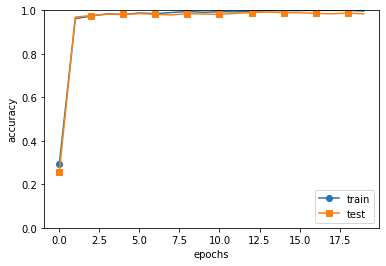

In [19]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

#시간이 너무 오래 걸릴 땐 데이터를 줄이자
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

network.save_params("params.pkl")
print("Saved Network Parameters!")

markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()